In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lmdb
import time

dataset = 'cifar100'
float_data_format = True

caffe_root = os.environ['CAFFE_PROJ_DIR']
print 'caffe_root ',caffe_root

sys.path.append(caffe_root + 'python')
sys.path.append(caffe_root + 'python/util')
import caffe
# from util_func import *

sys.path.append(caffe_root + 'python/caffe/proto')
import caffe_pb2

import sys
sys.path.append(caffe_root + 'python')
import caffe

# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.

data_dir=caffe_root+'data/cifar100/cluster_confusion_mat_9clusters_NIN/v0.0/'
model_dir = caffe_root + 'models/cifar100_NIN_float_crop_v2/9clusters/9clusters_v0.0/'
MODEL_FILE =model_dir + 'hdcnn_deploy.prototxt'
PRETRAINED = model_dir + 'hdcnn_iter_10000.caffemodel'
input_scale=255
num_branch=9

caffe_root  /home/zyan3/proj/caffe_private_hdcnn/


In [2]:
with open(caffe_root + 'data/cifar100/fine_label_names.txt') as cls_name_f:
    cls_name=[]
    for l in cls_name_f:
        cls_name += [l[:-1]]

In [3]:
mean_binary_file = caffe_root + 'data/%s/float_mean.binaryproto' % dataset
mean_npy_file = caffe_root + 'data/%s/float_mean.npy' % dataset

cifar100_mean_blob=caffe_pb2.BlobProto()
f=open(mean_binary_file,'rb')
f.seek(0, 2)
size = f.tell()
f.seek(0, 0)
data=f.read(size)
cifar100_mean_blob.ParseFromString(data)
f.close()
cifar100_mean = np.zeros((cifar100_mean_blob.channels,cifar100_mean_blob.height,cifar100_mean_blob.width))
ptr=0
for i in range(cifar100_mean_blob.channels):
    for j in range(cifar100_mean_blob.height):
        for k in range(cifar100_mean_blob.width):
            cifar100_mean[i,j,k]=cifar100_mean_blob.data[ptr]
            ptr+=1
np.save(mean_npy_file, cifar100_mean)

In [4]:
caffe.set_mode_gpu()
caffe.init_device(0)
# caffe.init_device(1)

In [5]:
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       mean=np.load(mean_npy_file),
                       channel_swap=(0,1,2),
                       input_scale=input_scale,
                       image_dims=(32,32))

In [6]:
replica_id = 0
layer_name = 'data'
print net.blobs(replica_id)[layer_name].num
print net.blobs(replica_id)[layer_name].channels
print net.blobs(replica_id)[layer_name].height
print net.blobs(replica_id)[layer_name].width
print net.blobs(replica_id)[layer_name].data.shape

100
3
26
26
(100, 3, 26, 26)


In [8]:
test_lmdb = lmdb.open(caffe_root + 'examples/cifar100/cifar100-float-lmdb/cifar100-test-lmdb')
test_txn = test_lmdb.begin()

In [9]:
'''collect testing image data'''
if 1:
    # keys=list(test_db.RangeIter(include_value=False))
    num_test = 10000
    test_imgs =[None]*num_test
    test_img_labels=np.zeros((num_test),np.int32)
    for i in range(num_test):
        if i%1000==0:
            print '%d out of %d' % (i+1, num_test)
        key = '%d' % i
#         string_data = test_db.Get(key)
        string_data = test_txn.get(key)
        datum = caffe_pb2.Datum()
        datum.ParseFromString(string_data)

        if float_data_format:
            data_array = np.asarray(datum.float_data, dtype=np.float32)
        else:
            data_array = np.fromstring(datum.data, dtype=np.uint8) 
            data_array = np.float32(data_array)
        
        data_array = data_array.reshape((datum.channels, datum.height, datum.width))
        data_array = np.transpose(data_array,(1,2,0))
        data_array /= 255.0    
        test_imgs[i] = data_array
        test_img_labels[i] = datum.label

1 out of 10000
1001 out of 10000
2001 out of 10000
3001 out of 10000
4001 out of 10000
5001 out of 10000
6001 out of 10000
7001 out of 10000
8001 out of 10000
9001 out of 10000


In [10]:
'''hdcnn single view test'''
st_time=time.time()
prediction = net.predict(test_imgs, oversample = False) 
pred_label = np.argmax(prediction,axis=1)
idx = np.nonzero(pred_label == test_img_labels)[0]
print 'testing accuracy w/o oversample: %5.4f' % (len(idx) / np.float32(len(test_imgs)))
ep_time=time.time()-st_time
print 'single view test elapsed time %3.2f seconds' % ep_time    

testing accuracy w/o oversample: 0.6550
single view test elapsed time 77.19 seconds


<Container object of 100 artists>

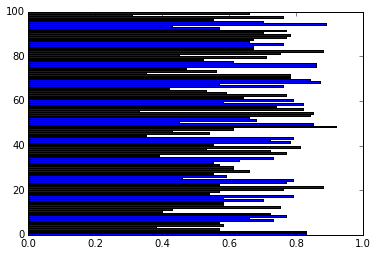

In [9]:
uni_label = np.unique(test_img_labels)
cls_num = len(uni_label)
'''plot class-wise accuracy'''
cls_accu = np.zeros((cls_num))
for i in range(len(uni_label)):
    idx = np.nonzero(test_img_labels==uni_label[i])[0]
    pred_label_ = pred_label[idx]
    test_img_labels_ = test_img_labels[idx]
    idx2 = np.nonzero(pred_label_ == test_img_labels_)[0]
    cls_accu[i] = len(idx2) / np.float32(len(test_img_labels_))
plt.figure()
plt.barh([i+0.5 for i in range(cls_num)],cls_accu,align='center')

In [10]:
'''hdcnn multi-view test'''
st_time=time.time()
prediction = net.predict(test_imgs, oversample = True)  
pred_label = np.argmax(prediction,axis=1)
idx = np.nonzero(pred_label == test_img_labels)[0]
print 'testing accuracy w/ oversample: %5.4f' % (len(idx) / np.float32(len(test_imgs)))
ep_time=time.time()-st_time
print 'multiview test elapsed time %4.3f seconds' % ep_time

testing accuracy w/ oversample: 0.6738
multiview test elapsed time 146.601 seconds
